In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from langchain.tools import tool
from langchain_community.tools.file_management.read import ReadFileTool
#from langchain_experimental.tools.python.tool import PythonREPLTool
from pydantic import BaseModel, Field
from IPython.display import display, HTML, Image
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
import os
#import json
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
#import subprocess

from langgraph.graph.message import add_messages 

import pandas as pd
load_dotenv()

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [2]:
df = pd.read_csv('mbpp_san_train.csv', usecols=['task_id','prompt','code','test_list'])
df.head()

,task_id,prompt,code,test_list
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'..."
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '..."
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr..."
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...


In [3]:
df['prompt'].iloc[0]

'Write a python function to find the first repeated character in a given string.'

In [4]:
class TestCode(BaseModel):
    test_code: str = Field(description="The python code for the test cases to validate given python code.")
    description: str = Field(description="A brief description of what the test cases are validating.")
    how_to_use: str = Field(description="Instructions on how to use the test cases.")

class SolutionCode(BaseModel):
    solution_code: str = Field(description="The solution code for the given python task.")
    description: str = Field(description="A brief description of the solution code.")
    how_to_use: str = Field(description="Instructions on how to use the solution code.")

E0000 00:00:1763641880.238141    4912 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


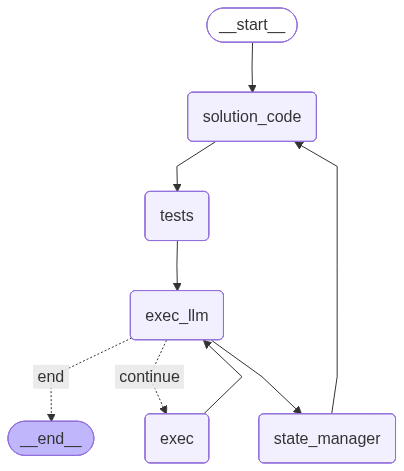

In [ ]:
# TOOLS
# code execution tool
import contextlib
import io
@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message."""
    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code)

        result = f.getvalue()
        print(f"RESULT IN EXECUTION: {result}")    
    except Exception as e:
            result = f"Error: {e}"
    return result

# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

solution_code_model = llm.with_structured_output(SolutionCode)
test_code_model = llm.with_structured_output(TestCode)


# STATE
class ExecutionState(BaseModel):
    tests_generated: bool = Field(default=False, description="Flag indicating if tests have been generated.")
    test_code: TestCode = None
    test_status: str = Field(default="", description="Status of the test execution.")   
    solution_code: SolutionCode = None
    messages: Annotated[list[AnyMessage], add_messages]
    


# NODES
def generate_code_tests(state: ExecutionState) -> dict:
    system_message = """
    You are an expert Python programmer. Write tests that can be executed directly without needing function definitions. 
    Use print statements to show test results.
    """
    instruction_message = """
    Write python test code for the following python code. The tests should print "PASSED" if all tests pass or show the specific error if any fail.
    
    Code to test: {solution_code}
    """
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=instruction_message.format(solution_code=state.solution_code.solution_code))
    ]
    
    response = test_code_model.invoke(messages)
    return {
        "test_code": response, 
        "tests_generated": True,
        "messages": [AIMessage(content=f"Generated test code: {response.test_code}")]
    }

def generate_solution_code(state: ExecutionState) -> dict:
    response = solution_code_model.invoke(state.messages)
    return {"solution_code": response, "messages": [AIMessage(content=f"Generated solution code: {response.solution_code}")]}

def exec_llm(state: ExecutionState) -> dict:
    execution_llm = llm.bind_tools([execute_code])
    
    # Check if the last message has tool calls that need to be executed
    if state.messages and state.messages[-1].tool_calls:
        # If there are tool calls, we should return the existing messages
        # The ToolNode will handle execution and add ToolMessages
        return {"messages": []}
    
    # INSTRUCTIONS
    system_message = """
    You are an expert Python code tester. You will be provided with python code. Run the code and return the output or any errors encountered. 
    """
    instruction_message = """
    Execute test code: {test_code} 
    """
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=instruction_message.format(test_code=state.test_code.test_code))
    ]
    
    result = execution_llm.invoke(messages)
    return {"messages": [result]}


# CONDITIONAL EDGE FUNCTION
def conditional_edge(state: ExecutionState) -> str:
    # Check the content of the last few messages for PASSED/FAILED status
    print(f"STATE MESSAGES from COND EDGE: {[msg.content for msg in state.messages[-3:]]}")
    
    # Look for PASSED in the last few messages
    for msg in reversed(state.messages[-3:]):
        if hasattr(msg, 'content') and msg.content:
            if 'PASSED' in msg.content:
                return "end"
            elif 'FAILED' in msg.content or 'Error:' in msg.content:
                return "retry"
    
    # Default to continue if we can't determine status
    return "continue"


# GRAPH

graph = StateGraph(ExecutionState)
graph.add_node("solution_code", generate_solution_code)
graph.add_node("tests", generate_code_tests)
graph.add_node("exec_llm", exec_llm)
graph.add_node("exec", ToolNode(tools=[execute_code]))

graph.add_edge(START, "solution_code")
graph.add_edge("solution_code", "tests")
graph.add_edge("tests", "exec_llm")
graph.add_edge("exec", "exec_llm")

# Modified conditional edges to properly handle the flow
graph.add_conditional_edges("exec_llm", conditional_edge, path_map={ "end": END, "retry": "solution_code", "continue": "exec" })



mbpp_graph = graph.compile()

mbpp_graph



In [76]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
"""
instruction_message = """
Write a solution for the following python task : {task}
"""


## EXECUTION
messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=df['prompt'][0])) ]

result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 15})

STATE MESSAGES from COND EDGE: ['Generated solution code: \ndef find_first_repeated_char(s):\n    seen = set()\n    for char in s:\n        if char in seen:\n            return char\n        seen.add(char)\n    return None\n', 'Generated test code: def test_find_first_repeated_char():\n    assert find_first_repeated_char("abcabc") == "a"\n    assert find_first_repeated_char("abcdef") == None\n    assert find_first_repeated_char("hello") == "l"\n    assert find_first_repeated_char("programming") == "r"\n    assert find_first_repeated_char("") == None\n    assert find_first_repeated_char("a") == None\n    assert find_first_repeated_char("aa") == "a"\n\ntest_find_first_repeated_char()\n\ndef find_first_repeated_char(s):\n    seen = set()\n    for char in s:\n        if char in seen:\n            return char\n        seen.add(char)\n    return None\n\n# The following code is to ensure that the tests run and print PASSED or the specific error\ntry:\n    test_find_first_repeated_char()\n    

GraphRecursionError: Recursion limit of 15 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [70]:
result

{'tests_generated': True,
 'test_code': TestCode(test_code='def test_find_first_repeated_char():\n    assert find_first_repeated_char("abcabc") == "a"\n    assert find_first_repeated_char("abcdef") == None\n    assert find_first_repeated_char("hello") == "l"\n    assert find_first_repeated_char("programming") == "r"\n    assert find_first_repeated_char("") == None\n    assert find_first_repeated_char("a") == None\n    assert find_first_repeated_char("aa") == "a"\n\ntest_find_first_repeated_char()\n\ndef find_first_repeated_char(s):\n    seen = set()\n    for char in s:\n        if char in seen:\n            return char\n        seen.add(char)\n    return None\n\n# The following code is to ensure that the tests run and print PASSED or the specific error\ntry:\n    test_find_first_repeated_char()\n    print("PASSED")\nexcept AssertionError as e:\n    print(f"FAILED: {e}")\nexcept Exception as e:\n    print(f"An unexpected error occurred: {e}")', description='Tests for the find_first_repe

In [27]:
assert find_first_repeated_char("abcabc") == "d"

AssertionError: 